<a href="https://colab.research.google.com/github/ymuto0302/base1_2021/blob/main/MAS2_SIRmodel_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIRモデル (ベースとなるコード)
SIR(Susceptible, Infectious, or Recovered)モデル: 感染症の拡大を予測する，伝統的なモデル

### モデルの仕様
- 最初に，一定数のエージェントを「感染」状態とする。
- エージェントは空間内をランダムに移動し，感染者と接触した（＝同じセルに属した）場合に感染する。
- 感染後，一定時間が経過すると回復し，再感染しない。

---
### 準備：mesa のインストール

In [ ]:
!pip install mesa

---
## SIRモデルのコード

In [ ]:
# 必要なクラスのインポート
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from enum import IntEnum

# エージェントの状態の定義
class State(IntEnum):
    SUSCEPTIBLE = 0 # 健康(感染する可能性がある)
    INFECTED = 1 # 感染した
    RECOVERED = 2 # 回復(耐性を有する)

class HumanAgent(Agent):
    # エージェントの初期化
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    # initial_state : 初期状態・・・class State を参照
    def __init__(self, unique_id, model, initial_state):
        super().__init__(unique_id, model)
        self.state = initial_state # エージェントの状態
        self.infection_time = -1 # 感染したタイミング

    # エージェントの移動
    def move(self):
        # Moore 近傍にて，移動可能な場所 (possible_steps) を探す
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, # 現在位置
            moore = True, # Moore 近傍
            include_center = False) # 中心を含まない
        
        # 移動先をランダムに決める
        new_position = self.random.choice(possible_steps)
        
        # 自分自身を new_position へ動かす
        self.model.grid.move_agent(self, new_position)
        
    # 他エージェントへの感染を試みる
    def try_infection(self):
        # 自分の位置 (self.pos) と同じセルにいる他のエージェントを探す
        cellmates = self.model.grid.get_cell_list_contents([self.pos])

        # 同じセルに他エージェントがいる場合の処理
        if len(cellmates) > 1: # cellmates は自分を含めてカウントするため，２以上のケースを考える
            for other in cellmates:
                # 自分自身が選ばれた場合，何もしない
                if other.unique_id == self.unique_id: continue
            
                # 相手が健康の場合，情け容赦なく感染させる
                if other.state == State.SUSCEPTIBLE:
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time # 感染したタイミングを記録

    def step(self):
        self.move() # 移動

        if self.state == State.INFECTED:
            # 感染後の経過時間
            t = self.model.schedule.time - self.infection_time
            
            # 感染後，一定時間(以下では 20ステップ)が経過すれば回復（免疫あり）の状態になる
            if t >= 20:
                self.state = State.RECOVERED
            else:
                self.try_infection()
            
class SIR_Model(Model):
    def __init__(self, N=100, width=30, height=30):
        self.num_human = N # エージェント数

        # ひとつのセルに複数のエージェントが存在してよいように MultiGrid とする
        # また，トーラス状とする。
        self.grid = MultiGrid(width, height, torus=True)

        # スケジューラの設定
        self.schedule = RandomActivation(self)
        
        # エージェントの生成
        for i in range(self.num_human):
            a = HumanAgent(i, self, State.SUSCEPTIBLE) # (注) 第２引数はモデル自身
            self.schedule.add(a) # エージェントのスケジュールへの追加
            
            # エージェントをランダムな位置に配置する
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
            # エージェントの初期状態として，その 10% を「感染」状態とする
            r = self.random.random()
            if r < 0.1:
                a.state = State.INFECTED
                a.infection_time = 0
                
        # DataCollector の定義：エージェントの状態を記録する
        self.data_collector = DataCollector(
            agent_reporters={"State": "state"}
        )
        
    def step(self):
        self.data_collector.collect(self) # データ収集
        self.schedule.step()
        
model = SIR_Model(N=200, width=30, height=30)
for i in range(150): # 150ステップ
    model.step()

---
## シミュレーションの可視化 (Google Colab 版)
タイムステップの進行とともにエージェントの状態がどのように移り変わるかを可視化する。

**(注意) 以下は Google Colab 上で動作するよう，ArtistAnimation を用いて可視化を実現している。  

In [ ]:
# ArtistAnimation を用いたアニメーション

import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.grid(False) # True)

kamishibai = [] # scatter plot を貯め込むためのリスト
def update_model(model):
    for _ in range(150): # 150 steps
        # 各エージェントの状態に応じて色分け
        colors = []
        for a in model.schedule.agents:
            if a.state == State.SUSCEPTIBLE:
                colors.append('blue')
            elif a.state == State.INFECTED:
                colors.append('orange')
            elif a.state == State.RECOVERED:
                colors.append('green')

        # 各エージェントの位置を取り出す
        positions = [[a.pos[0], a.pos[1]] for a in model.schedule.agents]

        # スライスで楽をしたいから numpy 配列へ変換
        import numpy as np
        positions = np.array(positions)

        # scatter plot を描き，貯め込む
        # im = [ax.scatter(positions[:,0], positions[:,1], c='blue')]
        im = [ax.scatter(positions[:,0], positions[:,1], c=colors, s=20)]

        kamishibai.append(im)

        # １ステップ進める
        model.step()

if __name__ == '__main__':
    model = SIR_Model(N=200, width=30, height=30)

    # ArtistAnimation() によるアニメ生成
    update_model(model)
    ani = animation.ArtistAnimation(fig, kamishibai) # , interval=200) 
    plt.close() # これをつけないと余分な座標平面が出てくる

In [ ]:
# 結果の表示 ・・・動き出すまでちょい時間を要する
from matplotlib import rc

rc('animation', html='jshtml') # Google Colab 特有の設定
ani

---
## 健常者数・感染者数・回復者数の推移
時間（タイムステップ）の進行に伴い，健康な者，感染者，回復者それぞれの人数がどのように推移するかを可視化する。

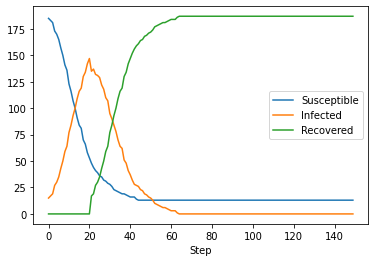

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Collector からエージェントに関するデータを受け取る
result = model.data_collector.get_agent_vars_dataframe()

# 並べ替え
X = pd.pivot_table(result.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)

# ラベルの再定義
labels = ['Susceptible','Infected','Recovered']
X.columns = labels

# 描画
X.plot()

In [ ]:
# (参考)集計結果を表示
X

Susceptible  Infected  Recovered
Step                                  
0             177        23          0
1             174        26          0
2             169        31          0
3             163        37          0
4             153        47          0
...           ...       ...        ...
145             6         0        194
146             6         0        194
147             6         0        194
148             6         0        194
149             6         0        194

[150 rows x 3 columns]